# Explore MovieLens dataset using Spark

In [1]:
import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import and setup the pyspark module
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql import functions as func
os.environ["PYSPARK_PYTHON"] = "python3"

## Data ETL, Data Exploration, Data Cleaning

In [3]:
spark = SparkSession \
            .builder \
            .appName("moive analysis") \
            .config("spark.some.config.option", "some-value") \
            .getOrCreate()

In [4]:
# load data
ratings = spark.read.load("/user/yg369/data/ratings.csv", format='csv', inferSchema = True, header = True)
users = spark.read.load("/user/yg369/data/users.csv", format='csv', inferSchema = True, header = True)
movies = spark.read.load("/user/yg369/data/movies.csv", format='csv', inferSchema = True, header = True)

In [5]:
# print data schema tree
print("ratings schema")
ratings.printSchema()
print("users schema")
users.printSchema()
print("movies schema")
movies.printSchema()

ratings schema
root
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: integer (nullable = true)

users schema
root
 |-- UserID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Zip-code: string (nullable = true)

movies schema
root
 |-- MovieID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Genres: string (nullable = true)



In [6]:
# count the number of missing values in each tags
print("Count Missing Value")

df_ls = [ratings, users, movies]
name_ls = ["ratings", "users", "movies"]

for i in range(len(df_ls)):
    print("\nFor {} data:".format(name_ls[i]))
    for column in df_ls[i].columns:
        print("Number of NULLs in column {} of {} data: ".format(column, name_ls[i]),
              df_ls[i].where(func.col(column).isNull()).count())

Count Missing Value

For ratings data:
Number of NULLs in column UserID of ratings data:  0
Number of NULLs in column MovieID of ratings data:  0
Number of NULLs in column Rating of ratings data:  0
Number of NULLs in column Timestamp of ratings data:  0

For users data:
Number of NULLs in column UserID of users data:  0
Number of NULLs in column Gender of users data:  0
Number of NULLs in column Age of users data:  0
Number of NULLs in column Occupation of users data:  0
Number of NULLs in column Zip-code of users data:  0

For movies data:
Number of NULLs in column MovieID of movies data:  0
Number of NULLs in column Title of movies data:  0
Number of NULLs in column Genres of movies data:  0


In [7]:
# since our data is complete, we don't need to clean the data

## Exploring Data Analysis Spark SQL and OLAP - Get Insights of Data

In [8]:
# print total number of users
print("Number of Users: ", users.select('UserID').distinct().count())

# print total number of movies
print("Number of Movies: ", movies.select('MovieID').distinct().count())

Number of Users:  6040
Number of Movies:  3883


In [9]:
# use Spark SQL
# create data view for Spark SQL
ratings.createOrReplaceTempView("Ratings")
users.createOrReplaceTempView("Users")
movies.createOrReplaceTempView("Movies")

### Focus on Users.csv

add users

In [10]:
# gender distribution
num_each_gender = users.select("Gender").groupby("Gender").count().withColumnRenamed("count", "Number_of_People")
num_each_gender.show()

+------+----------------+
|Gender|Number_of_People|
+------+----------------+
|     F|            1709|
|     M|            4331|
+------+----------------+



+--------+----------------+
|     Age|Number_of_People|
+--------+----------------+
|Under 18|             222|
|   18-24|            1103|
|   25-34|            2096|
|   35-44|            1193|
|   45-49|             550|
|   50-55|             496|
|     56+|             380|
+--------+----------------+

Plot the distribution of Number_of_People for each age:


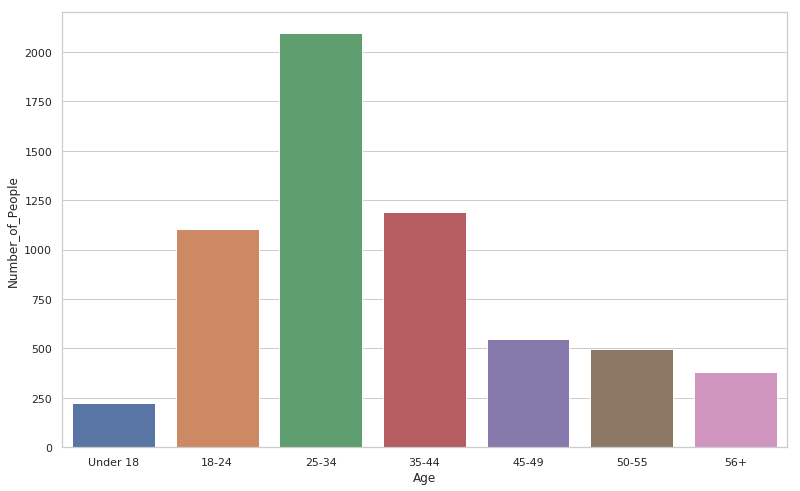

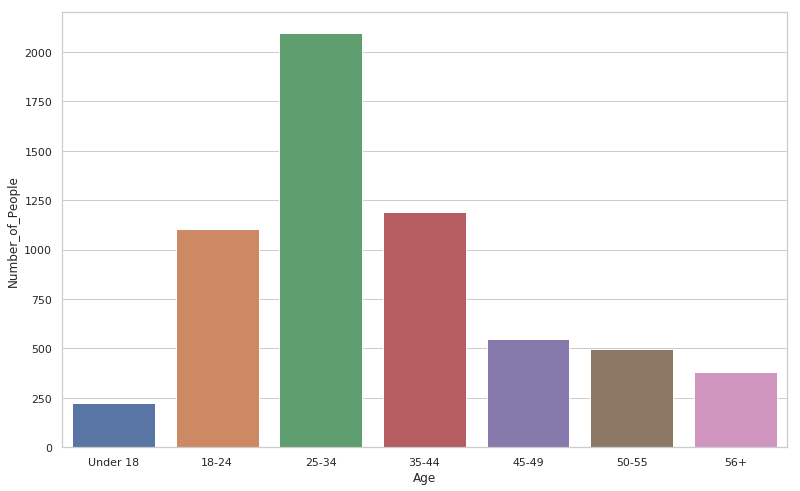

In [11]:
# age distribution
age_dict = {"Under 18": "1", "18-24": "18", "25-34": "25", "35-44": "35", "45-49": "45", "50-55": "50", "56+": "56"}
age_to_dict = func.udf(lambda row: age_dict[row], StringType())

num_each_age = users.select("Age").groupby("Age").count().withColumnRenamed("count", "Number_of_People")
num_each_age = num_each_age.sort(age_to_dict("Age"))
num_each_age.show()

# plot the distribution of Number_of_People for each age
print("Plot the distribution of Number_of_People for each age:")
num_each_age_df = num_each_age.toPandas()
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="Age", y="Number_of_People", data=num_each_age_df)
display(fig)

+------------------------+----------------+
|Occupation              |Number_of_People|
+------------------------+----------------+
|college/grad student    |759             |
|'other' or not specified|711             |
|executive/managerial    |679             |
|academic/educator       |528             |
|technician/engineer     |502             |
|programmer              |388             |
|sales/marketing         |302             |
|writer                  |281             |
|artist                  |267             |
|self-employed           |241             |
|doctor/health care      |236             |
|K-12 student            |195             |
|clerical/admin          |173             |
|scientist               |144             |
|retired                 |142             |
|lawyer                  |129             |
|customer service        |112             |
|homemaker               |92              |
|unemployed              |72              |
|tradesman/craftsman     |70    

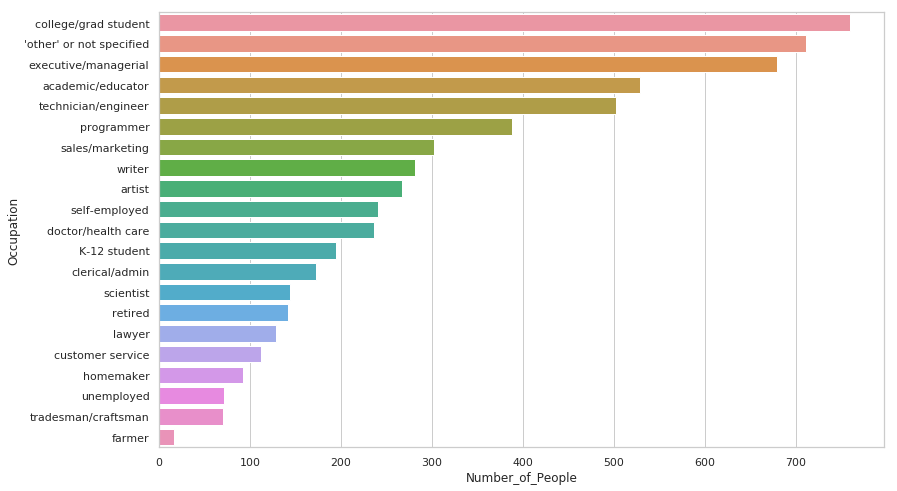

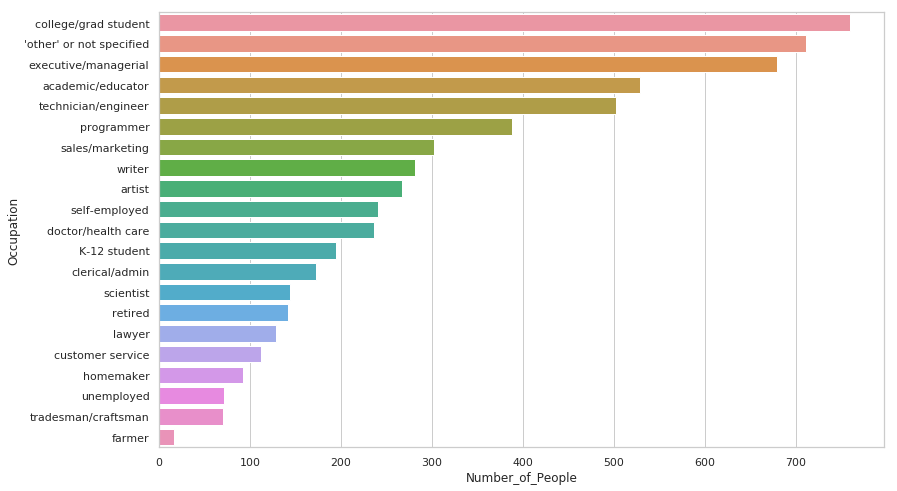

In [12]:
# career distribution
num_each_occup = users.select("Occupation") \
                      .groupby("Occupation") \
                      .count().withColumnRenamed("count", "Number_of_People")
num_each_occup = num_each_occup.sort(func.col("Number_of_People").desc())
num_each_occup.show(21, truncate=False)

# plot the distribution of Number_of_People for each occupation
print("Plot the distribution of Number_of_People for each occupation:")
num_each_occup_df = num_each_occup.toPandas()
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="Number_of_People", y="Occupation", data=num_each_occup_df)
display(fig)

In [13]:
# average number of movies rated by one person， average ratings, could use describe
people_rated_distribution = spark.sql("SELECT Users.UserID, COUNT(Ratings.MovieID) AS Number_of_Rated_Movies, \
                                            AVG(Ratings.Rating) AS AVG_Movies_Rating \
                                       FROM Users \
                                       LEFT JOIN Ratings \
                                       ON Users.UserID = Ratings.UserID \
                                       GROUP BY Users.UserID \
                                       ORDER BY Users.UserID")
print("Total number of movies one person rated and the average rating he/she rated:")
people_rated_distribution.show(20)
people_rated_distribution_df = people_rated_distribution.toPandas()

# count of movies
dict_num_rated = dict(people_rated_distribution_df["Number_of_Rated_Movies"].describe())

print("Total number of users:\t{}".format(dict_num_rated["count"]))
print("For each user:")
print("\tAverage number of movies who rated:         \t{}".format(dict_num_rated["mean"]))
print("\tSTD of the distribution of number of movies:\t{}".format(dict_num_rated["std"]))
print("\tMinimum number of movies who rated:         \t{}".format(dict_num_rated["min"]))
print("\t25% number of movies who rated:             \t{}".format(dict_num_rated["25%"]))
print("\tMedian number of movies who rated:          \t{}".format(dict_num_rated["50%"]))
print("\t75% number of movies who rated:             \t{}".format(dict_num_rated["75%"]))
print("\tMaximum number of movies who rated:         \t{}".format(dict_num_rated["max"]))
print("\n")

# avg of ratings
dict_avg_rating = dict(people_rated_distribution_df["AVG_Movies_Rating"].describe())

print("Total number of users:\t{}".format(dict_avg_rating["count"]))
print("For each user:")
print("\tMean value of average rating who gave:         \t{}".format(dict_avg_rating["mean"]))
print("\tSTD of the distribution of average rating:\t{}".format(dict_avg_rating["std"]))
print("\tMinimum number of average rating:        \t{}".format(dict_avg_rating["min"]))
print("\t25% number of average rating:            \t{}".format(dict_avg_rating["25%"]))
print("\tMedian number of average rating:            \t{}".format(dict_avg_rating["50%"]))
print("\t75% number of average rating:            \t{}".format(dict_avg_rating["75%"]))
print("\tMaximum number of average rating:        \t{}".format(dict_avg_rating["max"]))
print("\n")

people_rated_distribution.createOrReplaceTempView("People_Profile")

Total number of movies one person rated and the average rating he/she rated:
+------+----------------------+------------------+
|UserID|Number_of_Rated_Movies| AVG_Movies_Rating|
+------+----------------------+------------------+
|     1|                    53| 4.188679245283019|
|     2|                   129|3.7131782945736433|
|     3|                    51|3.9019607843137254|
|     4|                    21| 4.190476190476191|
|     5|                   198|3.1464646464646466|
|     6|                    71|3.9014084507042255|
|     7|                    31|  4.32258064516129|
|     8|                   139| 3.884892086330935|
|     9|                   106|3.7358490566037736|
|    10|                   401| 4.114713216957606|
|    11|                   137|3.2773722627737225|
|    12|                    23|3.8260869565217392|
|    13|                   108| 3.388888888888889|
|    14|                    25|              3.32|
|    15|                   201|3.3233830845771144|
|    

In [14]:
#number of movies rated according to different genders, careers and ages
#ratings according to different genders, careers and ages

# gender
gender_rated_distribution = spark.sql("SELECT Users.Gender, \
                                           AVG(People_Profile.Number_of_Rated_Movies) AS AVG_Number_of_Rated_Movies, \
                                           AVG(People_Profile.AVG_Movies_Rating) AS AVG_Movies_Rating \
                                       FROM Users \
                                       LEFT JOIN People_Profile \
                                       ON Users.UserID = People_Profile.UserID \
                                       GROUP BY Users.Gender")
print("Total number of movies one person rated and the average rating with respect to gender:")
gender_rated_distribution.show()

Total number of movies one person rated and the average rating with respect to gender:
+------+--------------------------+-----------------+
|Gender|AVG_Number_of_Rated_Movies|AVG_Movies_Rating|
+------+--------------------------+-----------------+
|     F|        144.20128730251608| 3.72946520833511|
|     M|         174.0404063726622|3.692145314161539|
+------+--------------------------+-----------------+



In [15]:
# ages
age_dict = {"Under 18": "1", "18-24": "18", "25-34": "25", "35-44": "35", "45-49": "45", "50-55": "50", "56+": "56"}
age_to_dict = func.udf(lambda row: age_dict[row], StringType())

age_rated_distribution = spark.sql("SELECT Users.Age, \
                                        AVG(People_Profile.Number_of_Rated_Movies) AS AVG_Number_of_Rated_Movies, \
                                        AVG(People_Profile.AVG_Movies_Rating) AS AVG_Movies_Rating \
                                    FROM Users \
                                    LEFT JOIN People_Profile \
                                    ON Users.UserID = People_Profile.UserID \
                                    GROUP BY Users.Age")
age_rated_distribution = age_rated_distribution.sort(age_to_dict("Age"))
print("Total number of movies one person rated and the average rating with respect to age:")
age_rated_distribution.show()

Total number of movies one person rated and the average rating with respect to age:
+--------+--------------------------+------------------+
|     Age|AVG_Number_of_Rated_Movies| AVG_Movies_Rating|
+--------+--------------------------+------------------+
|Under 18|        122.57207207207207|3.6210549912690917|
|   18-24|        166.39709882139618|3.6206713499568233|
|   25-34|        188.71946564885496| 3.667680477530927|
|   35-44|        166.80888516345348|  3.74337189302922|
|   45-49|                    152.06| 3.770965227387365|
|   50-55|         146.1491935483871|3.7954517960940963|
|     56+|        102.05263157894737| 3.834175722104778|
+--------+--------------------------+------------------+



Plot the distribution of AVG_Number_of_Rated_Movies for each age:


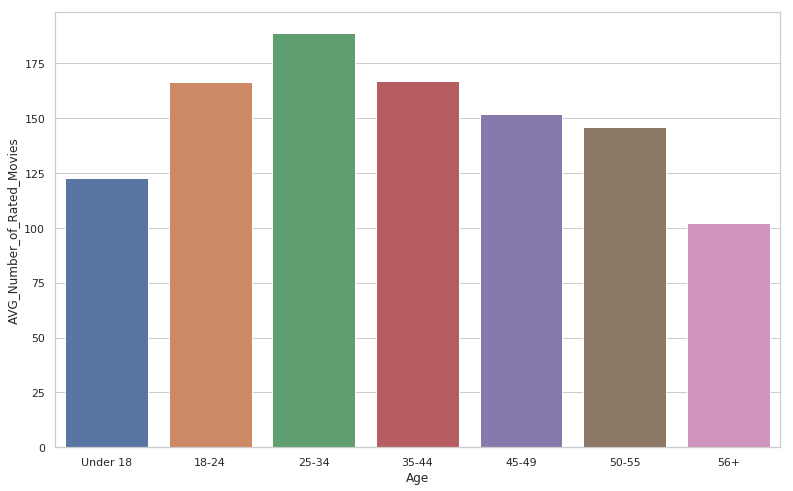

Plot the distribution of AVG_Movies_Rating for each age:


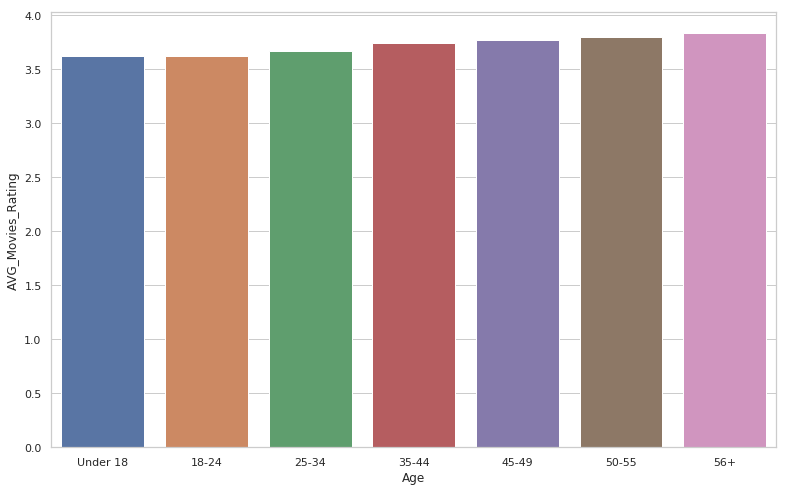

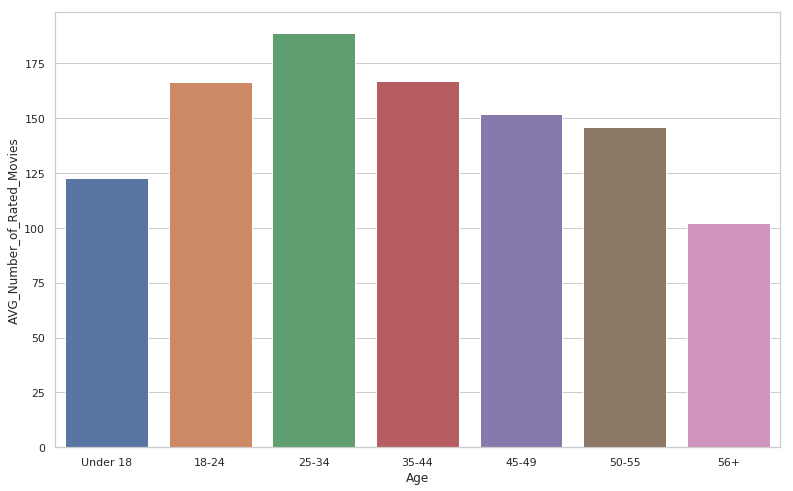

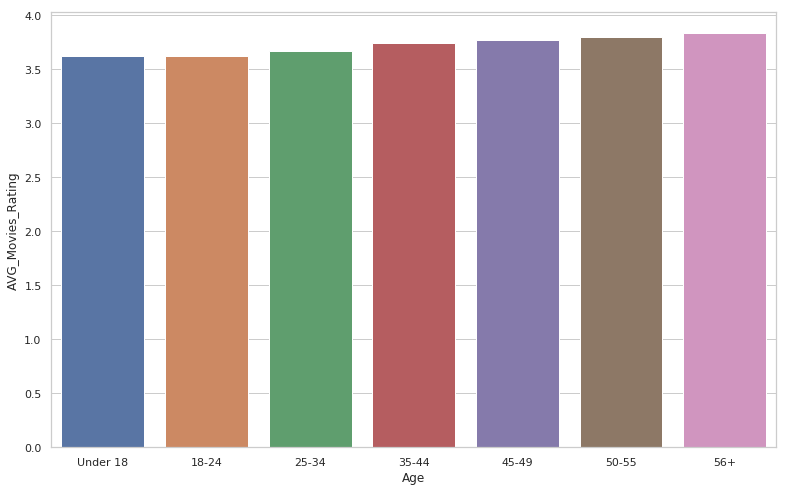

In [16]:
# plot the distribution of AVG_Number_of_Rated_Movies for each age
print("Plot the distribution of AVG_Number_of_Rated_Movies for each age:")
age_rated_distribution_df = age_rated_distribution.toPandas()
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="Age", y="AVG_Number_of_Rated_Movies", data=age_rated_distribution_df)
display(fig)

# plot the distribution of AVG_Movies_Rating for each age
print("Plot the distribution of AVG_Movies_Rating for each age:")
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="Age", y="AVG_Movies_Rating", data=age_rated_distribution_df)
display(fig)

In [17]:
# occupation
occup_dict = {"'other' or not specified": 0, "academic/educator": 1, "artist": 2, \
              "clerical/admin": 3, "college/grad student": 4, "customer service": 5, \
              "doctor/health care": 6, "executive/managerial": 7, "farmer": 8, "homemaker": 9,\
              "K-12 student": 10, "lawyer": 11, "programmer": 12, "retired": 13,\
              "sales/marketing": 14, "scientist": 15, "self-employed": 16, "technician/engineer": 17,\
              "tradesman/craftsman": 18, "unemployed": 19, "writer": 20}
occup_to_dict = func.udf(lambda row: occup_dict[row], IntegerType())

occup_rated_distribution = spark.sql("SELECT Users.Occupation, \
                                          AVG(People_Profile.Number_of_Rated_Movies) AS AVG_Number_of_Rated_Movies, \
                                          AVG(People_Profile.AVG_Movies_Rating) AS AVG_Movies_Rating \
                                      FROM Users \
                                      LEFT JOIN People_Profile \
                                      ON Users.UserID = People_Profile.UserID \
                                      GROUP BY Users.Occupation")
# for test
# occup_rated_distribution.show()
occup_rated_distribution = occup_rated_distribution.sort(occup_to_dict("Occupation"))
print("Total number of movies one person rated and the average rating with respect to occupation:")
occup_rated_distribution.show(21)

Total number of movies one person rated and the average rating with respect to occupation:
+--------------------+--------------------------+------------------+
|          Occupation|AVG_Number_of_Rated_Movies| AVG_Movies_Rating|
+--------------------+--------------------------+------------------+
|'other' or not sp...|        183.54289732770746|3.6755457861389385|
|   academic/educator|        161.64962121212122|  3.71614916726315|
|              artist|        187.52059925093633|3.7182912130959034|
|      clerical/admin|        182.79190751445086|3.7621251710994827|
|college/grad student|        172.63768115942028| 3.662267473386752|
|    customer service|        195.08928571428572| 3.604606176345917|
|  doctor/health care|        157.64830508474577|3.7590162087160697|
|executive/managerial|        155.26509572901327| 3.723901200626952|
|              farmer|         159.1764705882353| 3.403524865315416|
|           homemaker|        123.31521739130434| 3.727726495478749|
|        K-1

Plot the distribution of AVG_Number_of_Rated_Movies for each occupation:


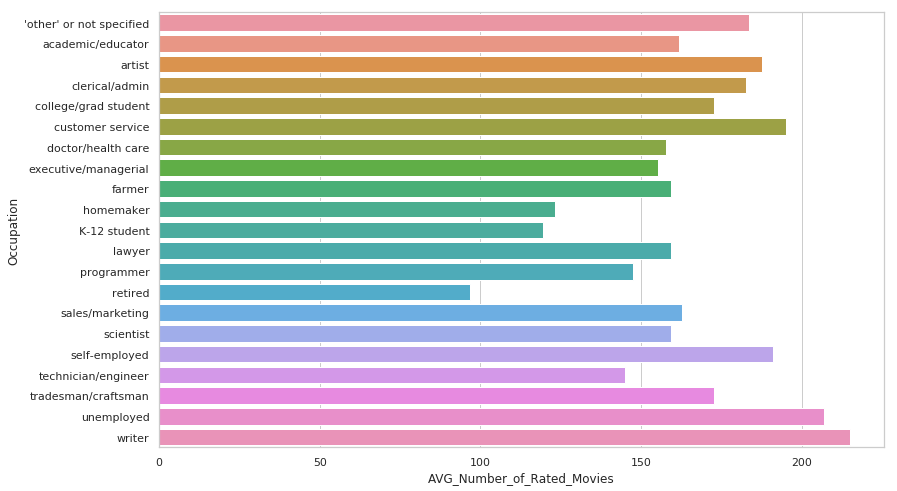

Plot the distribution of AVG_Movies_Rating for each occupation:


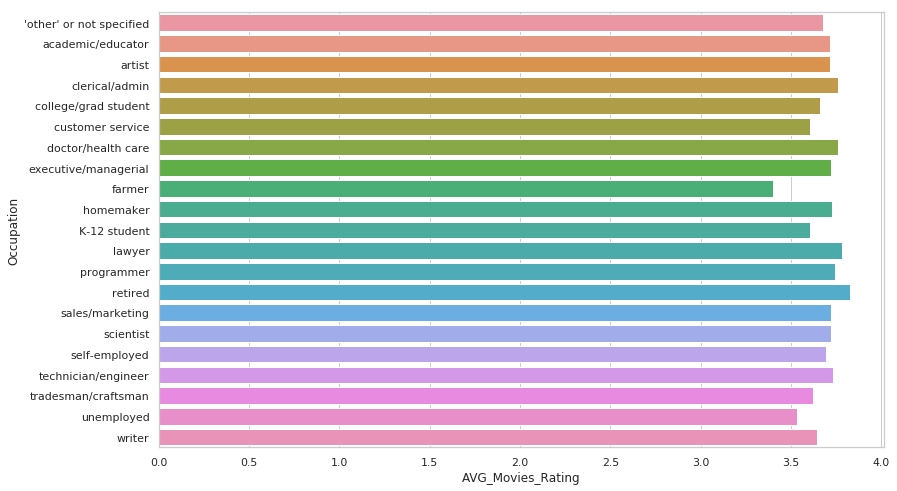

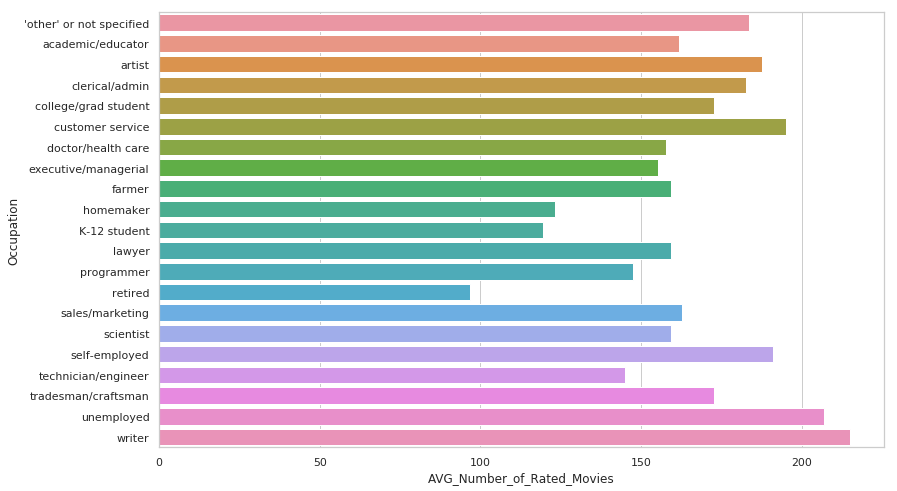

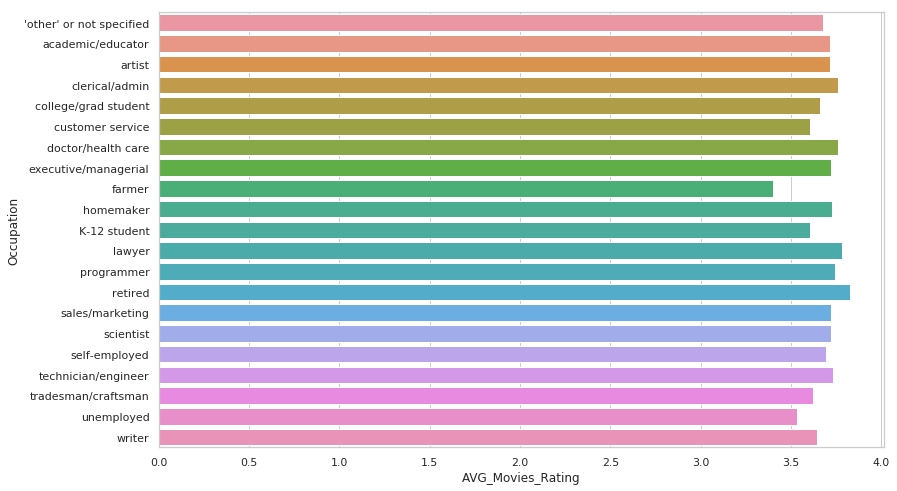

In [18]:
# plot the distribution of AVG_Number_of_Rated_Movies for each occupation
print("Plot the distribution of AVG_Number_of_Rated_Movies for each occupation:")
occup_rated_distribution_df = occup_rated_distribution.toPandas()
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="AVG_Number_of_Rated_Movies", y="Occupation", data=occup_rated_distribution_df)
display(fig)

# plot the distribution of AVG_Movies_Rating for each occupation
print("Plot the distribution of AVG_Movies_Rating for each occupation:")
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="AVG_Movies_Rating", y="Occupation", data=occup_rated_distribution_df)
display(fig)

### Focus on Movies.csv

In [19]:
# count the number of rated movies
num_movies_rated = spark.sql("SELECT COUNT(DISTINCT(Movies.MovieID)) AS Number_of_Rated_Movies\
                              FROM Movies \
                              LEFT JOIN Ratings \
                              ON Movies.MovieID = Ratings.MovieID \
                              WHERE Ratings.Rating IS NOT NULL")
num_movies_rated.show(truncate=False)

# list the number of movies just rated by only 1 people
print("\n{} out of {} movies are rated by only one user\n".format(
        ratings.select("MovieID").groupby("MovieID").count().select("MovieID").where("count==1").count(), \
        movies.select('MovieID').distinct().count()))

# list the unrated movies in our data number shall be 0
movies_not_rated = spark.sql("SELECT DISTINCT(Movies.Title) AS List_of_Unrated_Movies\
                              FROM Movies \
                              LEFT JOIN Ratings \
                              ON Movies.MovieID = Ratings.MovieID \
                              WHERE Ratings.Rating IS NULL")
print("Number of movies that are not rated by users:\t{}\nFollowing is the list of not rated movies".format(
       movies_not_rated.count()))
movies_not_rated.show(truncate=False)

+----------------------+
|Number_of_Rated_Movies|
+----------------------+
|3706                  |
+----------------------+


114 out of 3883 movies are rated by only one user

Number of movies that are not rated by users:	177
Following is the list of not rated movies
+-------------------------------------------------------------+
|List_of_Unrated_Movies                                       |
+-------------------------------------------------------------+
|Mondo (1996)                                                 |
|Lost Son, The (1999)                                         |
|Crows and Sparrows (1949)                                    |
|Storefront Hitchcock (1997)                                  |
|Halfmoon (Paul Bowles - Halbmond) (1995)                     |
|Children Are Watching us, The (Bambini ci guardano, I) (1942)|
|Love in Bloom (1935)                                         |
|Breaks, The (1999)                                           |
|Prerokbe Ognja (1995)    

# distribution of number of rating for each movies:
movies_rate_distribution = spark.sql("SELECT Movies.Title, COUNT(Ratings.Rating) AS Number_of_Rating\
                                      FROM Movies \
                                      LEFT JOIN Ratings \
                                      ON Movies.MovieID = Ratings.MovieID \
                                      GROUP BY Movies.Title \
                                      ORDER BY Number_of_Rating")
movies_rate_distribution = movies_rate_distribution.toPandas()

print("Movies with most frequent ratings: \n{}\n".format(
    movies_rate_distribution.sort_values(by=["Number_of_Rating"], ascending=False).head(20)))
print("\n")
print("Movies with least frequent ratings: \n{}\n".format(
    movies_rate_distribution.sort_values(by=["Number_of_Rating"], ascending=True).head(20)))
print("\n")

print("Statistical descriptive analysis on frequency of ratings for each movies:")

dict_num_rating = dict(movies_rate_distribution["Number_of_Rating"].describe())

print("Total number of movies:\t{}".format(dict_num_rating["count"]))
print("For each movie:")
print("\tAverage frequency of ratings:        \t{}".format(dict_num_rating["mean"]))
print("\tSTD of the distribution of frequency:\t{}".format(dict_num_rating["std"]))
print("\tMinimum frequency of ratings:        \t{}".format(dict_num_rating["min"]))
print("\t25% frequency of ratings:            \t{}".format(dict_num_rating["25%"]))
print("\tMedian frequency of ratings:            \t{}".format(dict_num_rating["50%"]))
print("\t75% frequency of ratings:            \t{}".format(dict_num_rating["75%"]))
print("\tMaximum frequency of ratings:        \t{}".format(dict_num_rating["max"]))
print("\n")

print("Number of movies that only have one rating:")
print(movies_rate_distribution[movies_rate_distribution["Number_of_Rating"] == 1].count())
print("\n")

print("Number of movies that only have less than 10 rating:")
print(movies_rate_distribution[movies_rate_distribution["Number_of_Rating"] < 10].count())

In [21]:
# split genres and create a new column Genre for further process
movies_split_genre = movies.withColumn("Genre", func.explode(func.split(movies.Genres, '\|')))
movies_split_genre.show(20)    # for test

+-------+--------------------+--------------------+----------+
|MovieID|               Title|              Genres|     Genre|
+-------+--------------------+--------------------+----------+
|      1|    Toy Story (1995)|Animation|Childre...| Animation|
|      1|    Toy Story (1995)|Animation|Childre...|Children's|
|      1|    Toy Story (1995)|Animation|Childre...|    Comedy|
|      2|      Jumanji (1995)|Adventure|Childre...| Adventure|
|      2|      Jumanji (1995)|Adventure|Childre...|Children's|
|      2|      Jumanji (1995)|Adventure|Childre...|   Fantasy|
|      3|Grumpier Old Men ...|      Comedy|Romance|    Comedy|
|      3|Grumpier Old Men ...|      Comedy|Romance|   Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|    Comedy|
|      4|Waiting to Exhale...|        Comedy|Drama|     Drama|
|      5|Father of the Bri...|              Comedy|    Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|    Action|
|      6|         Heat (1995)|Action|Crime|Thri...|    

In [22]:
# get distinct 18 Genres
genre_list = movies_split_genre.select("Genre").distinct().sort(["Genre"]).toPandas()
print("Number of Genres:\t{}\n".format(len(genre_list)))
print(genre_list)

Number of Genres:	18

          Genre
0        Action
1     Adventure
2     Animation
3    Children's
4        Comedy
5         Crime
6   Documentary
7         Drama
8       Fantasy
9     Film-Noir
10       Horror
11      Musical
12      Mystery
13      Romance
14       Sci-Fi
15     Thriller
16          War
17      Western


In [23]:
# aggregate all the movie with same genres
movie_each_genre = movies_split_genre.groupBy("Genre").agg(func.concat_ws(", ", func.collect_list(movies["Title"])))
movie_each_genre = movie_each_genre.withColumnRenamed("concat_ws(, , collect_list(Title))", "Movie_List")
movie_each_genre = movie_each_genre.withColumn("Movie_Name", func.split("Movie_List", ","))

# count the number of movies per genres
movie_list_len = func.udf(lambda s: len(s), IntegerType())
movie_each_genre = movie_each_genre.select("Genre", "Movie_List", movie_list_len("Movie_Name").alias("Number_of_Movies"))
movie_each_genre = movie_each_genre.orderBy("Number_of_Movies", ascending=False)

# print genre with its movie list and number of movies
movie_each_genre.select("Genre", "Number_of_Movies").show()

print("Movie list for each genre")
print(movie_each_genre.toPandas())

+-----------+----------------+
|      Genre|Number_of_Movies|
+-----------+----------------+
|      Drama|            2058|
|     Comedy|            1471|
|     Action|             616|
|   Thriller|             610|
|    Romance|             581|
|     Horror|             442|
|  Adventure|             353|
| Children's|             335|
|     Sci-Fi|             332|
|      Crime|             257|
|        War|             179|
|Documentary|             167|
|    Musical|             145|
|  Animation|             140|
|    Mystery|             135|
|    Fantasy|              91|
|    Western|              84|
|  Film-Noir|              55|
+-----------+----------------+

Movie list for each genre
          Genre                                         Movie_List  \
0         Drama  Waiting to Exhale (1995), American President, ...   
1        Comedy  Toy Story (1995), Grumpier Old Men (1995), Wai...   
2        Action  Heat (1995), Sudden Death (1995), GoldenEye (1...   
3      Thri

Plot the distribution of movies for each genre:


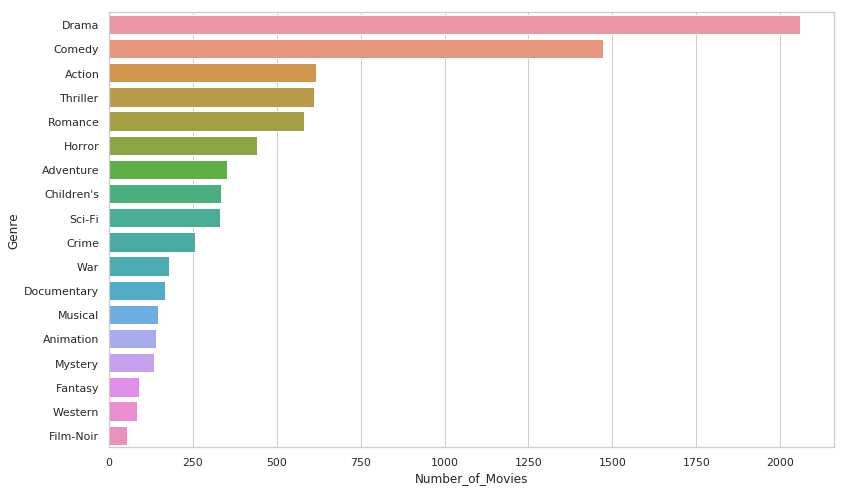

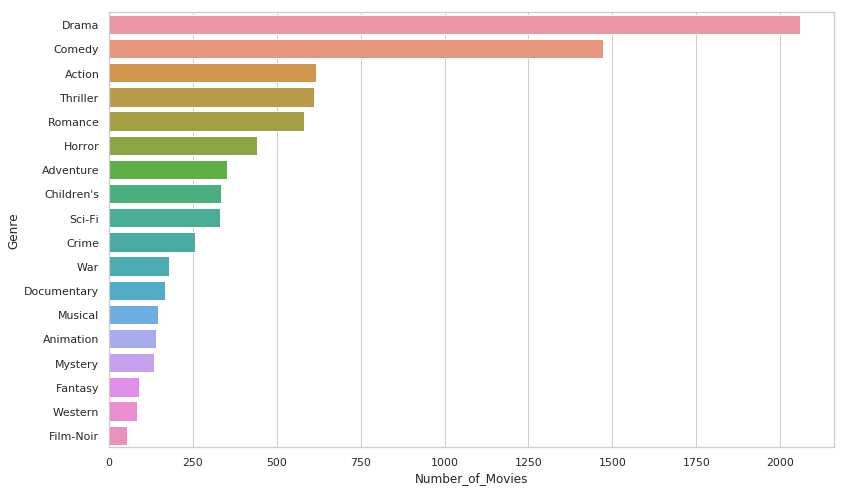

In [24]:
# plot the distribution of movies for each genre
print("Plot the distribution of movies for each genre:")
movie_each_genre_df = movie_each_genre.toPandas()
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="Number_of_Movies", y="Genre", data=movie_each_genre_df)
display(fig)

### Explore ratings.csv

In [25]:
# Statistical descriptive analysis on each genres:
movies_split_genre.createOrReplaceTempView("Movies_List")
genres_avg_rate = spark.sql("SELECT Movies_List.Genre, AVG(Ratings.Rating) AS AVG_Rating\
                             FROM Movies_List \
                             LEFT JOIN Ratings \
                             ON Movies_List.MovieID = Ratings.MovieID \
                             GROUP BY Movies_List.Genre \
                             ORDER BY AVG_Rating DESC")
genres_avg_rate.show()

genres_avg_rate = genres_avg_rate.toPandas()

dict_genres_avg_rate = dict(genres_avg_rate["AVG_Rating"].describe())
print("Total number of categories of movies:\t{}".format(dict_genres_avg_rate["count"]))
print("For each movie:")
print("\tAverage ratings for all categories:\t{}".format(dict_genres_avg_rate["mean"]))
print("\tSTD of ratings of all categories:  \t{}".format(dict_genres_avg_rate["std"]))
print("\tMinimum average ratings:           \t{}".format(dict_genres_avg_rate["min"]))
print("\t25%:                               \t{}".format(dict_genres_avg_rate["25%"]))
print("\tMedian:                               \t{}".format(dict_genres_avg_rate["50%"]))
print("\t75%:                               \t{}".format(dict_genres_avg_rate["75%"]))
print("\tMaximum average ratings:           \t{}".format(dict_genres_avg_rate["max"]))

+-----------+------------------+
|      Genre|        AVG_Rating|
+-----------+------------------+
|  Film-Noir| 4.075187558184108|
|Documentary| 3.933122629582807|
|        War| 3.893326717935996|
|      Drama| 3.766332232342065|
|      Crime| 3.708678543141273|
|  Animation| 3.684868223500335|
|    Mystery|3.6681019463387923|
|    Musical|3.6655189849035708|
|    Western|3.6377701493980563|
|    Romance| 3.607464598740535|
|   Thriller|3.5704660480809784|
|     Comedy| 3.522098827752538|
|     Action|3.4911849357368414|
|  Adventure| 3.477256948332624|
|     Sci-Fi| 3.466521291339784|
|    Fantasy| 3.447370595851354|
| Children's| 3.422034743579087|
|     Horror| 3.215013222318226|
+-----------+------------------+

Total number of categories of movies:	18.0
For each movie:
	Average ratings for all categories:	3.6251287887254984
	STD of ratings of all categories:  	0.2062818460842317
	Minimum average ratings:           	3.215013222318226
	25%:                               	3.48073894

Plot the distribution of AVG_Rating for each genre:


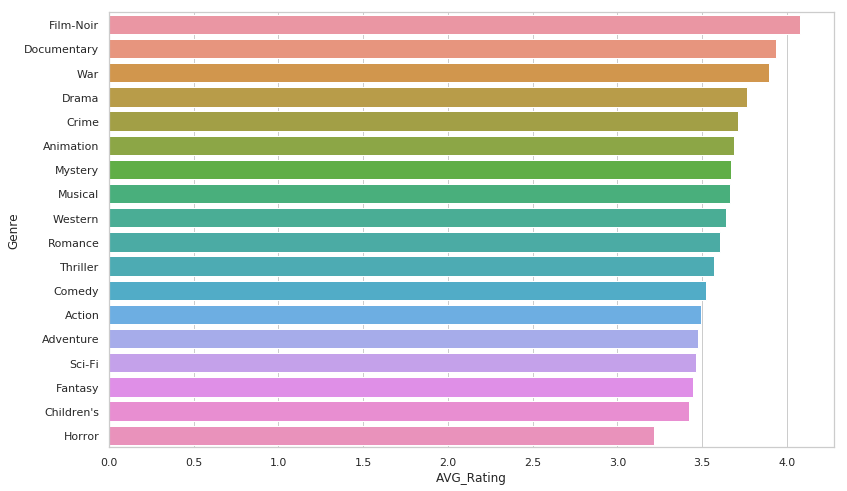

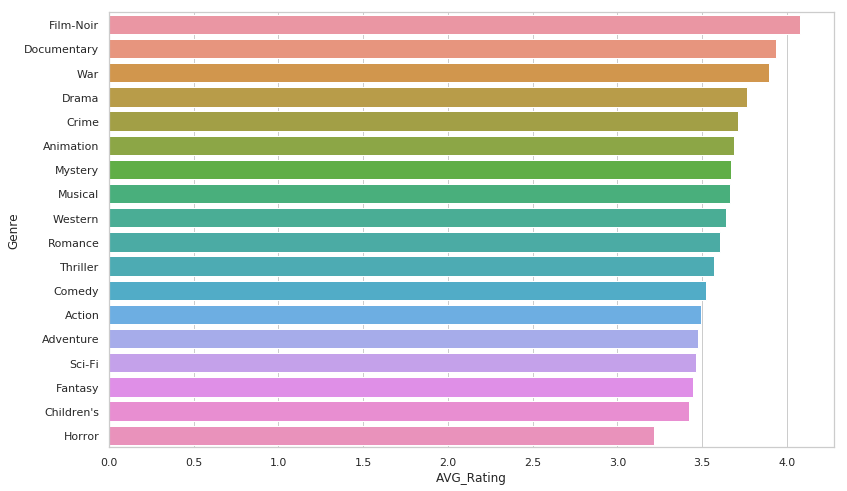

In [26]:
# plot the distribution of AVG_Rating for each genre
print("Plot the distribution of AVG_Rating for each genre:")
fig = plt.figure(figsize=(13,8))
sns.set(style="whitegrid", rc={"lines.linewidth": 4.5})
sns.barplot(x="AVG_Rating", y="Genre", data=genres_avg_rate)
display(fig)

### Most polarising movies (Marmite movies)

Next, we will try to answer the question, What are the most polarising movies? These are the movies that divide opinon, with people tending to rate them either really highly or really poorly. We will refer to these as Marmite movies. Again, we only want to consider movies that achieve some minimum number of ratings - we will stick with our previous threshold of 500 ratings.

To approach this, we will look for the movies with the highest standard deviation in rating. This is a measure of how much the data varies from the mean, so in this case, how much a movie's ratings vary around its mean rating. A high standard deviation would suggest that the movie's ratings are highly variable. There are other approaches to this as well, for instance, what proportion of the ratings are very positive or very negative.

In [27]:
ratings_stddev = ratings \
                 .groupBy("MovieID") \
                 .agg(func.count("UserID").alias("Num_of_Ratings"), 
                      func.avg(func.col("Rating")).alias("AVG_of_Rating"),
                      func.stddev(func.col("Rating")).alias("STD_of_Rating")
                     ) \
                 .where("Num_of_Ratings > 100") \
                 .sort(func.col("STD_of_Rating").desc())
# for test
# ratings_stddev.show(20)
marmite_movies = movies \
                 .join(ratings_stddev, ratings_stddev.MovieID == movies.MovieID) \
                 .sort(ratings_stddev.STD_of_Rating.desc()) \
                 .drop(ratings_stddev.MovieID)
marmite_movies.show(20)

+-------+--------------------+--------------------+--------------+------------------+------------------+
|MovieID|               Title|              Genres|Num_of_Ratings|     AVG_of_Rating|     STD_of_Rating|
+-------+--------------------+--------------------+--------------+------------------+------------------+
|   1924|Plan 9 from Outer...|       Horror|Sci-Fi|           249|2.6345381526104417|1.4559983991255796|
|   2314|      Beloved (1998)|               Drama|           104|3.1346153846153846|1.3728129459672882|
|   3864|Godzilla 2000 (Go...|Action|Adventure|...|           143|2.6923076923076925|1.3646996740797475|
|   2459|Texas Chainsaw Ma...|              Horror|           247| 3.222672064777328| 1.332448440768303|
|    231|Dumb & Dumber (1994)|              Comedy|           660|3.1924242424242424|1.3213331436461841|
|   1483|        Crash (1996)|      Drama|Thriller|           141|2.7588652482269502|1.3196358221648996|
|   2710|Blair Witch Proje...|              Horror|    